## Importing the data

In [1]:
# Import the data
from scipy.io import loadmat
data = loadmat('../data/beamforming/RF.mat', simplify_cells = True)
RF = data['RF']
param = data['param']

In [2]:
# Peek into param dictionary
print("param =", param.keys())
print(RF.shape) 
print('sampling fequency =', param['RxFreq'])

param = dict_keys(['TwFreq', 'NbHcycle', 'DutyCycle', 'ApodFct', 'Depth', 'ReceivingElts', 'RxFreq', 'TGC', 'pitch'])
(2176, 128)
sampling fequency = 36


It is important to note that the units are:
- MHz for frequency 
- mm for length

## Beamforming 

In order to reconstruct the point wise signal $s(z,x)$ the mesured echos at time $t$ and position $x_i$, noted as $RF(x_i,t)$, one shall add coherently add the latter contributions coming from every element of the ultrasonic array and accounting for the travel time $\tau(x_i,x,z)$ of the wave coming from point $(x,z)$ to the element at position $x_i$.
Therefore the signal is given by the formula
$$
s(x,z) = \int_{x-a}^{x+a} RF(x_1, \tau(x_1, x, z))dx_1
$$


with travel time being 
$$
\tau (x_1, x, z) = \left(z+ \sqrt{z^2+(x-x_1)^2}\right)/c
$$

### Implementation of the reconstruction 

In [3]:
import numpy as np

In [4]:
# Set the domain parameters
c0 = 1.524 # speed of sound in water (mm/us)
fs = param['RxFreq'] # sampling frequency (MHz)
T = np.size(RF, 0) / fs # sampling time (us)
Depth = c0 * T / 2 # total depth (mm)
dx = param['pitch'] # lateral sampling distance (mm)

# Domain discretization
X = np.arange(0, np.size(RF, 1)) * dx # lateral domain (mm)
#Z = np.linspace(0, Depth, np.size(RF, 0)) # axial domain (mm)
Z = (c0 * np.arange(0,np.size(RF, 0))/fs)/2  # axial domain (mm)

In [5]:
# compute the travel time from (x, 0) to (x, z) to (x1, 0) (us)
def travel_time(x, x1, z, c = c0):
    return (z + np.sqrt((x - x1)**2 + z**2)) / c

def travel_time_idx(x, x1, z, c = c0):
    return np.round(travel_time(x, x1, z, c) * fs).astype(int)

In [6]:
# z = Z[2000]; print("z =", z)
# x = X[11]; print("x =", x)
# X_elts = X
# Tau = travel_time(x, X_elts, z)
# Tau_discrete = np.round(Tau * param['RxFreq']).astype(int)
# print("Tau =", Tau)
# print(len(np.unique(Tau_discrete)))
# RF[Tau_discrete,:]

In [21]:
# set imaging domain
Imaging_domain = Z[(Z>1) & (Z<35)]

S = np.zeros((len(Imaging_domain), len(X)))
X_elts = X

for i in range(len(Imaging_domain)):
     for j in range(len(X)):
        x, z = X[j], Imaging_domain[i] # Current imaging point       
        Tau = travel_time(x, X_elts , z) # Time for wave to travel from element at x to imaging point to element at x1
        Tau_discrete = np.round(Tau * param['RxFreq']).astype(int) # Discretize the time

        RF_contributions = RF[Tau_discrete,:]
        S[i,j] = np.sum(RF_contributions)
        
S_abs = np.abs(S)
S_abs = S_abs / np.max(S_abs)
np.where(S_abs == 0)

(array([ 523,  523,  943,  943, 1241, 1241, 1312, 1312, 1569, 1569]),
 array([ 60,  67,  49,  78,   7, 120,  48,  79,  49,  78]))

/tmp/ipykernel_22273/156669469.py:4: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(S_abs), extent=[X[0], X[-1], Imaging_domain[-1], Imaging_domain[0]])


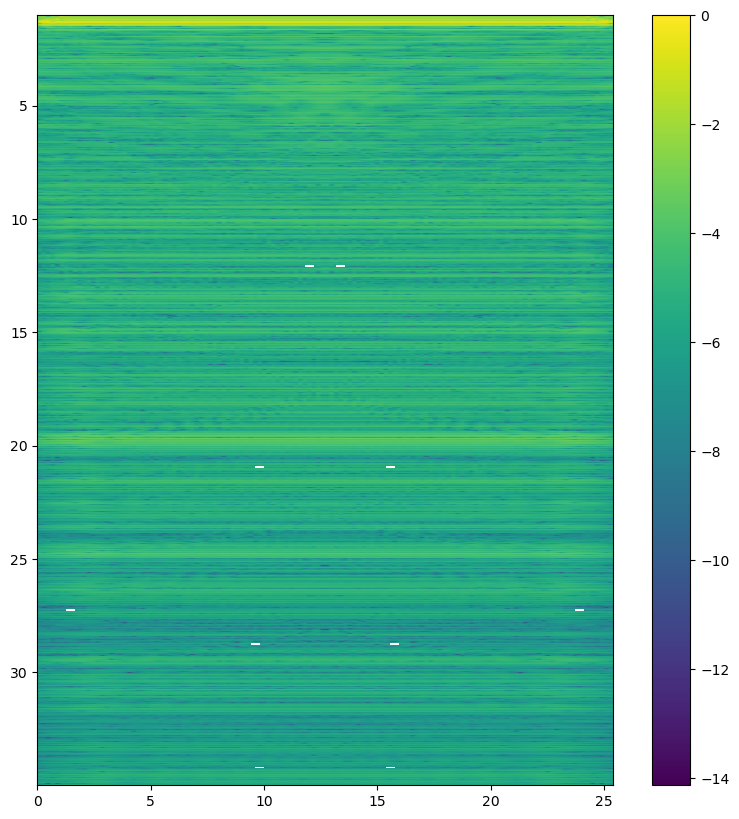

In [23]:
# Plot the surface S = S(x, z)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.imshow(np.log(S_abs), extent=[X[0], X[-1], Imaging_domain[-1], Imaging_domain[0]])
plt.colorbar()